# Analyzing the Value Premium

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model that extends William Sharpe's CAPM with a Size Factor and a Value Factor:
<br><br>
$$
E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML
$$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor performance of the CAPM, it has become, together with Fama/French's extended 5-Factor Model, the standard  model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) saw the largest drawdown in history since the financial crisis 2004, erasing half of its 100-year cumulative outperformance. Sceptics claim that both premia are not related to risk and should unsurpringly vanish once their existence becomes common knowledge.
<br>
This notebook provides an analysis of the factors that drive the value premium and shows that it cannot be concluded that the value premium is dead.

**Data sources:**
* Kenneth French's Academic Portfolios (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
  * In particular *Fama/French 5 Factors* and *6 Portfolios Formed on Size and Book-to-Market (2 x 3)*
* Robert Shiller's History of Bond Rates (http://www.econ.yale.edu/~shiller/data.htm)

## Analysis

#### Setting up the Data and Descriptive Statistics

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from finance_data import FrenchReader, ShillerReader

In [281]:
plt.style.use("seaborn-bright")
plt.rcParams["figure.figsize"] = (12,6)

In [282]:
bond_rate = ShillerReader.cape()["10-Year Interest Rate"] / 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, bond_rate], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate"]]
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367
...,...,...,...,...,...,...,...,...
2021-08-01,0.0290,-0.0048,-0.0013,-0.0026,-0.0167,0.0252,0.0000,0.012800
2021-09-01,-0.0437,0.0080,0.0509,-0.0194,0.0208,0.0157,0.0000,0.013700
2021-10-01,0.0665,-0.0228,-0.0044,0.0174,-0.0148,0.0321,0.0000,0.015800
2021-11-01,-0.0155,-0.0135,-0.0053,0.0738,0.0160,0.0082,0.0000,0.015600


In [283]:
portfolio_data = FrenchReader("6_Portfolios_2x3").read()
for key in portfolio_data.keys():
    print(key)

Average Value Weighted Returns Monthly
Average Equal Weighted Returns Monthly
Average Value Weighted Returns Annual
Average Equal Weighted Returns Annual
Number of Firms in Portfolios
Average Market Cap
Value Weight Average of BE/ME
Value Weight Average of BE_FYt-1/ME_June
Value Weight Average of OP
Value Weight Average of investment


---

**Since 2004, the value premium had its largest drawdown in historiy and shed half of its cumulative outperformance since 1927**

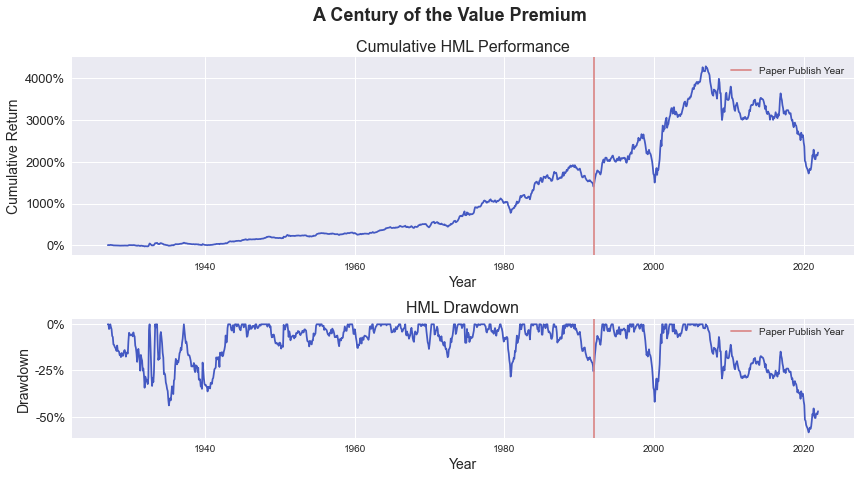

In [286]:
df["HML cumulative"] = (1+df["HML"]).cumprod()
df["HML drawdown"] = df["HML cumulative"] / df["HML cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(14,7))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
yticks = np.linspace(0, (df["HML cumulative"]-1).max() // 10 * 10, 5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].plot(df["HML cumulative"]-1, color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")
axes[0].legend();

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
yticks = np.linspace(-1, 0, 5)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].plot(df["HML drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")
axes[1].legend();

**Neither factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions the models out-of-sample performance to price equity risk.**

In [298]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.76% per month with a t-statistic of 3.35.
...the SMB factor returned an average of 0.14% per month with a t-statistic of 0.80.
...the HML factor returned an average of 0.17% per month with a t-statistic of 1.02.

Since 2015,...
...the RMW factor returned an average of 0.36% per month with a t-statistic of 1.66.
...the CMA factor returned an average of -0.15% per month with a t-statistic of -0.75.
